# Approach
Let's first consider what makes scientific publications difficult to read.
The text can be difficult because it contains the following: 
1. complex grammatical structures (compound sentences, passive voice, etc.). 
2. unusual vocabulary (technical jargon, scientific terminology) referring to сomplex concepts that require deep knowledge in a certain area.

The first point is usually perceived as an error, so any author would eliminate it before it gets into the final publication. Any remaining complexity would therefore be a type 2 complexity.

This leads to the conclusion that a bag-of-words representation contains most of the information needed to evaluate the complexity in question.
Shallow ML models have a good reputation for dealing with bag-of-words representations, so I will focus on them in this notebook.

# Setup

In [9]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
import pickle
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load parsed data

In [10]:
with open('data/X_train.txt', 'r', encoding='utf-8') as f:
    X_train = f.readlines()
with open('data/y_train.txt', 'r', encoding='utf-8') as f:
    y_train = [float(i) for i in f.readlines()]
    
with open('data/X_test.txt', 'r', encoding='utf-8') as f:
    X_test = f.readlines()
with open('data/y_test.txt', 'r', encoding='utf-8') as f:
    y_test = [float(i) for i in f.readlines()]

# Preprocessing
Russian is a highly [inflected language](https://en.wikipedia.org/wiki/Fusional_language). This means that the word (or [lexeme](https://en.wikipedia.org/wiki/Lexeme), to be precise) can have different forms to express tense, case, number, etc.
In order to treat different forms of the same lexeme as a single entity we need to reduce all these different forms to the "standard form".

In [11]:
# https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
import nltk
nltk.download("stopwords")
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
tokenizer = nltk.RegexpTokenizer(r"\w+")

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
          and token != '\n' \
          and token.strip() not in punctuation
          ]
    text = " ".join(tokens)
    return text

    
def preprosses_corpus(corpus):
    corpus_clean = []
    for text in tqdm(corpus):
        corpus_clean.append(preprocess_text(text))
    return corpus_clean

# X_train_clean = preprosses_corpus(X_train)
# X_test_clean = preprosses_corpus(X_test)
    
# with open('X_train_clean.txt', 'w', encoding='utf-8') as f:
#     for text in tqdm(X_train_clean):
#         f.write(text)
        
# with open('X_test_clean.txt', 'w', encoding='utf-8') as f:
#     for text in tqdm(X_test_clean):
#         f.write(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
with open('data/X_train_clean.txt', 'r', encoding='utf-8') as f:
    X_train_clean = f.readlines()
with open('data/X_test_clean.txt', 'r', encoding='utf-8') as f:
    X_test_clean = f.readlines()   

# Vectorizing and modeling

In [13]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=10000)

from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer()

model = CatBoostRegressor(iterations=1000,
                            # task_type="GPU",
                            # devices='1',
                            )

# model = CatBoostRegressor(iterations=2,
#                           learning_rate=1,
#                           depth=2)

text_regression = Pipeline([('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer()),
                                 ('model', model)])

In [ ]:
start_time = time.time()
text_regression.fit(X_train_clean, y_train)
print((time.time() - start_time))

In [21]:
print(text_regression['model'] is model)
model.save_model('catboost_model')

# Evaluation

In [22]:
preds = text_regression.predict(X_test_clean)
mse = mean_squared_error(y_test, preds)
sqrtmse = np.sqrt(mse)
print(sqrtmse)

0.9239455097775063


Text(0, 0.5, 'Predicted values')

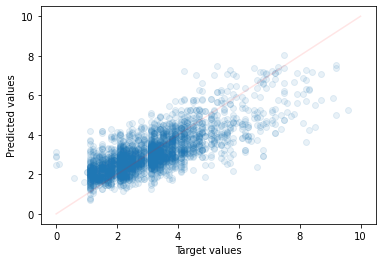

In [23]:
plt.scatter(y_test, preds, alpha=0.1)
plt.plot([0,10],[0,10], c='r', alpha=0.1)
plt.xlabel("Target values")
plt.ylabel("Predicted values")

In [18]:
pickle.dump(text_regression, open('text_regression_10000_idf_on', 'wb'))
# text_regression = pickle.load(open('text_regression_10000', 'rb'))